In [1]:
!pip install gensim # requires restarting the kernel after installation
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import gensim.downloader as api

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/train_data.csv')
val_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/val_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/test_data.csv')

# Separate features and labels for train and validation
X_train, y_train = train_data['text'], train_data['label']
X_val, y_val = val_data['text'], val_data['label']

In [4]:
# Check if labels exist in the test data
if 'label' in test_data.columns:
    has_labels = True
    X_test, y_test = test_data['text'], test_data['label']
else:
    has_labels = False
    X_test = test_data['text']

In [5]:
# Preprocess text for Word2Vec
X_train_tokens = X_train.apply(lambda x: x.lower().split())
X_val_tokens = X_val.apply(lambda x: x.lower().split())
X_test_tokens = X_test.apply(lambda x: x.lower().split())


In [9]:
# Load the GloVe model
word2vec_model = api.load("glove-twitter-100")

In [10]:
# Convert the text into vectors
def vectorize_text(model, text_tokens):
    vectors = [model[word] for word in text_tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
X_train_vectors = np.array([vectorize_text(word2vec_model, tokens) for tokens in X_train_tokens])
X_val_vectors = np.array([vectorize_text(word2vec_model, tokens) for tokens in X_val_tokens])
X_test_vectors = np.array([vectorize_text(word2vec_model, tokens) for tokens in X_test_tokens])

In [11]:
# Train SVM Model with Linear Kernel
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_vectors, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [12]:
def plot_classification_report(report, title):
    report_df = pd.DataFrame(report).T
    plt.figure(figsize=(10, 8))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f', cbar=False)
    plt.title(title)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground Truth')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_proba, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

Validation set accuracy: 0.8378455400398974


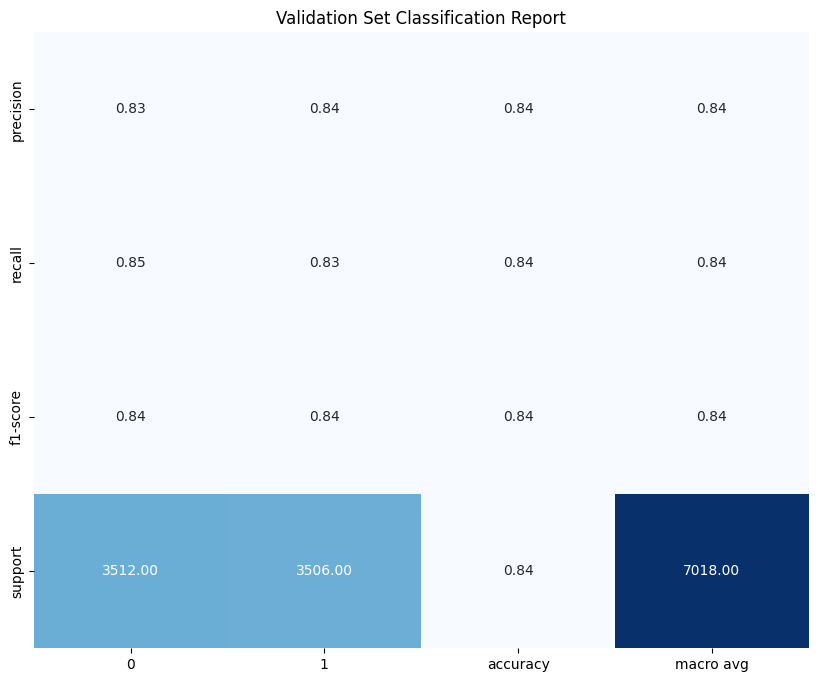

In [13]:
# Evaluate validation accuracy and plot the classification report
y_val_pred = svm.predict(X_val_vectors)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation set accuracy:", val_accuracy)
classification_report_val = classification_report(y_val, y_val_pred, output_dict=True)
plot_classification_report(classification_report_val, 'Validation Set Classification Report')

In [14]:
# Evaluate testing set
y_test_pred = svm.predict(X_test_vectors)

Test set accuracy: 0.8506697064690795
Classification report on test set:

Confusion Matrix:


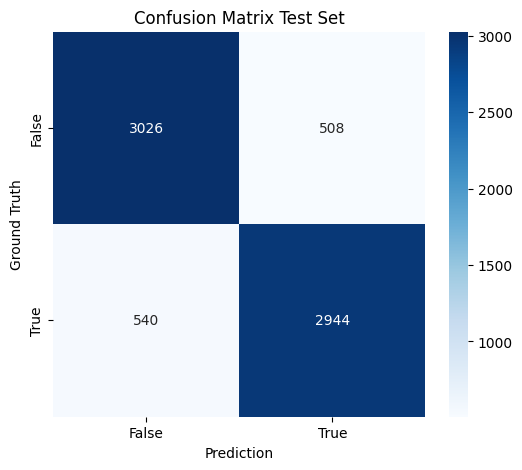


ROC Curve:


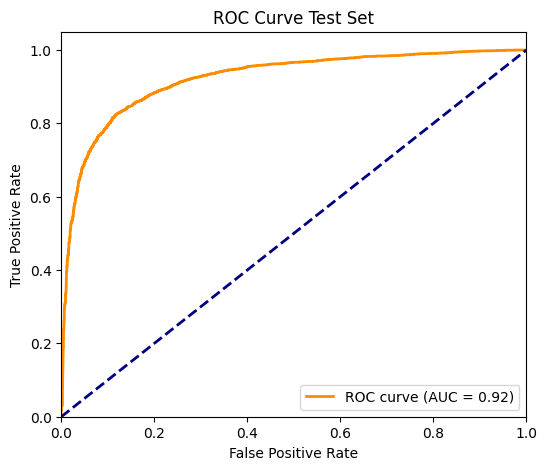


Precision-Recall Curve:


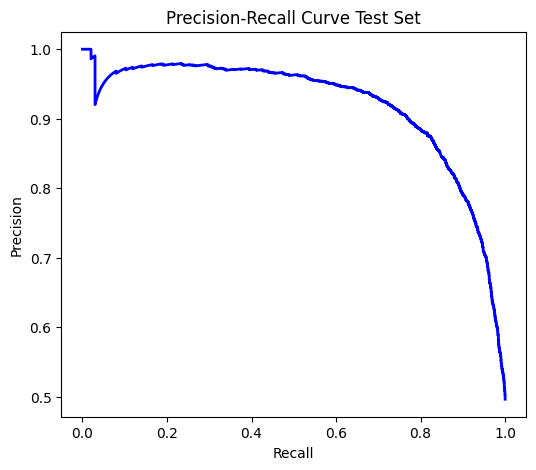


Classification Report for Test Set:


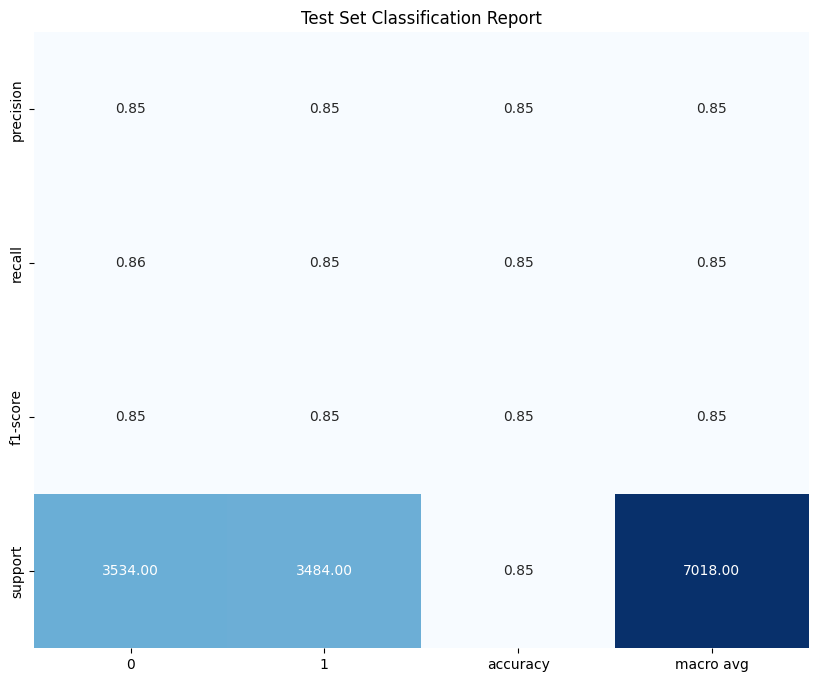

In [17]:
if has_labels:
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Test set accuracy:", test_accuracy)
    print("Classification report on test set:")
    classification_report_test = classification_report(y_test, y_test_pred, output_dict=True)

    # Confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_test, y_test_pred, 'Confusion Matrix Test Set')

    # ROC Curve
    print("\nROC Curve:")
    plot_roc_curve(y_test, svm.predict_proba(X_test_vectors)[:, 1], 'ROC Curve Test Set')

    # Precision-Recall Curve
    print("\nPrecision-Recall Curve:")
    plot_precision_recall_curve(y_test, svm.predict_proba(X_test_vectors)[:, 1], 'Precision-Recall Curve Test Set')

    # Classification Report for Test Set
    print("\nClassification Report for Test Set:")
    plot_classification_report(classification_report_test, 'Test Set Classification Report')
else:
    test_data['predicted_label'] = y_test_pred
    test_data.to_csv('test_predictions_unlabeled.csv', index=False)